In [ ]:
# address = "https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip"
# !wget $address -O data.zip

In [ ]:
# !unzip ./data.zip -d ./data

In [107]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

dataset_path = "./data/FullIJCNN2013"
gt_file = os.path.join(dataset_path, "gt.txt")

# Load ground truth annotations
columns = ["Image", "LeftCol", "TopRow", "RightCol", "BottomRow", "ClassID"]
annotations = pd.read_csv(gt_file, sep=";", names=columns)

# Select 3 sample images
sample_images = annotations["Image"].unique()[3:6]


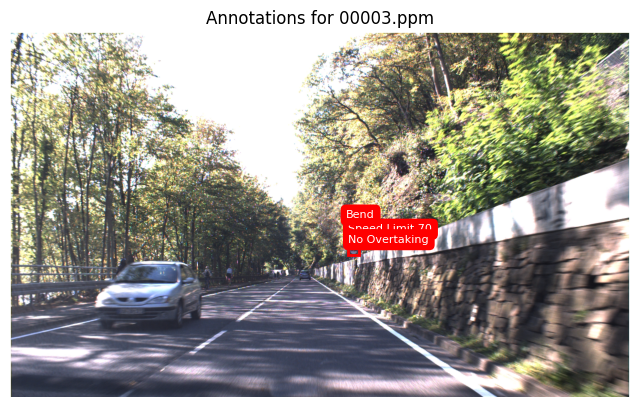

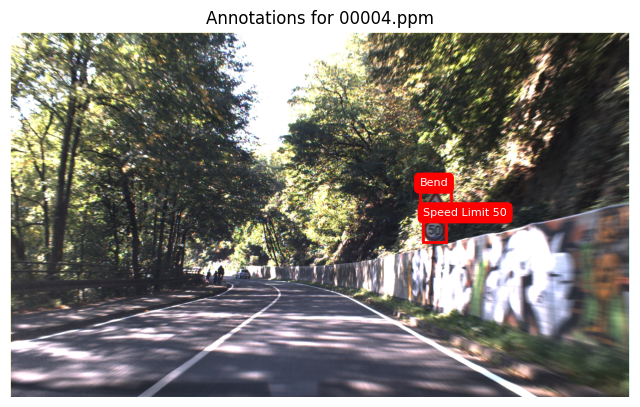

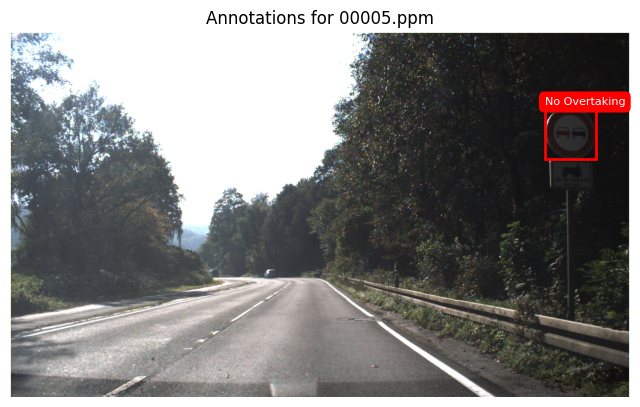

In [108]:
# Class names corresponding to IDs
class_names = {
    0: "Speed Limit 20",
    1: "Speed Limit 30",
    2: "Speed Limit 50",
    3: "Speed Limit 60",
    4: "Speed Limit 70",
    5: "Speed Limit 80",
    6: "Restriction Ends 80",
    7: "Speed Limit 100",
    8: "Speed Limit 120",
    9: "No Overtaking",
    10: "No Overtaking (Trucks)",
    11: "Priority at Next Intersection",
    12: "Priority Road",
    13: "Give Way",
    14: "Stop",
    15: "No Traffic Both Ways",
    16: "No Trucks",
    17: "No Entry",
    18: "Danger",
    19: "Bend Left",
    20: "Bend Right",
    21: "Bend",
    22: "Uneven Road",
    23: "Slippery Road",
    24: "Road Narrows",
    25: "Construction",
    26: "Traffic Signal",
    27: "Pedestrian Crossing",
    28: "School Crossing",
    29: "Cycles Crossing",
    30: "Snow",
    31: "Animals",
    32: "Restriction Ends",
    33: "Go Right",
    34: "Go Left",
    35: "Go Straight",
    36: "Go Right or Straight",
    37: "Go Left or Straight",
    38: "Keep Right",
    39: "Keep Left",
    40: "Roundabout",
    41: "Restriction Ends (Overtaking)",
    42: "Restriction Ends (Overtaking Trucks)"
}

# Function to display images with class names and background for annotations
def display_image_with_class_names(image_name, annotations, dataset_path, class_names):
    img_path = os.path.join(dataset_path, image_name)
    image = Image.open(img_path)

    # Plot image
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(image)

    # Get annotations for the image
    image_annotations = annotations[annotations["Image"] == image_name]

    # Plot bounding boxes
    for _, row in image_annotations.iterrows():
        bbox = patches.Rectangle(
            (row["LeftCol"], row["TopRow"]),
            row["RightCol"] - row["LeftCol"],
            row["BottomRow"] - row["TopRow"],
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(bbox)

        # Get class name for the current annotation
        class_name = class_names.get(row["ClassID"], "Unknown")

        # Set background color for the annotation text
        ax.text(
            row["LeftCol"], row["TopRow"] - 5, class_name,
            color="white", fontsize=8,
            bbox=dict(facecolor="red", edgecolor="none", boxstyle="round,pad=0.5")
        )

    plt.title(f"Annotations for {image_name}")
    plt.axis("off")
    plt.show()

# Display the 3 images with class names and background for annotations
for image_name in sample_images:
    display_image_with_class_names(image_name, annotations, dataset_path, class_names)


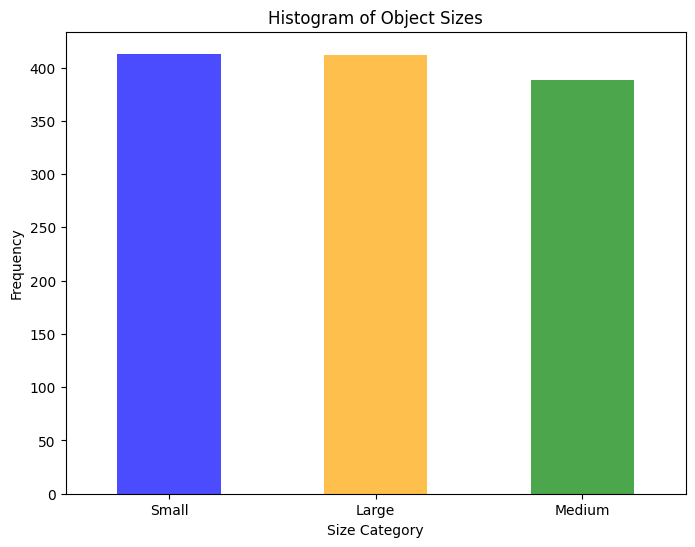

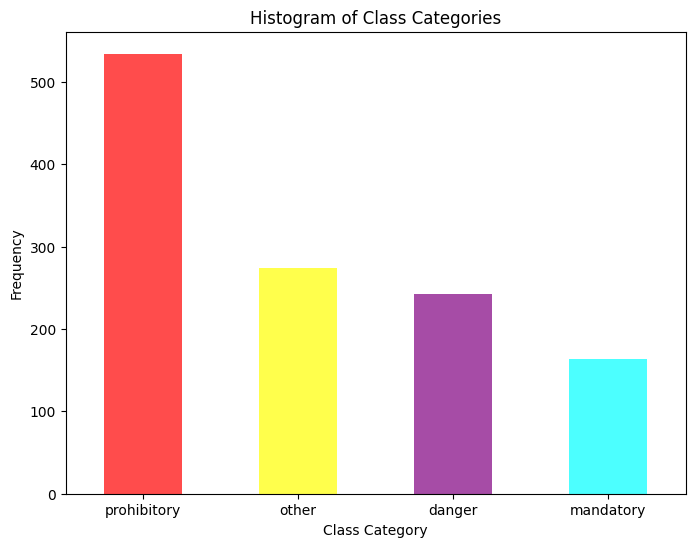

In [109]:
import numpy as np

# Define thresholds for size categories
SMALL_THRESHOLD = 32
MEDIUM_THRESHOLD = 45

# Map classes to broader categories
class_categories = {
    "prohibitory": list(range(0, 6)) + list(range(7, 11)) + [15, 16],
    "danger": [11, 15, 16] + list(range(18, 32)),
    "mandatory": list(range(33, 41)),
    "other": [6, 12, 13, 14, 17, 32, 41, 42],
}

# Add a column for width in the annotations DataFrame
annotations["Width"] = annotations["RightCol"] - annotations["LeftCol"]

# Label size categories
def label_size(width):
    if width < SMALL_THRESHOLD:
        return "Small"
    elif width <= MEDIUM_THRESHOLD:
        return "Medium"
    else:
        return "Large"

# Define class mapping
def map_class_id(original_id):
    if original_id in class_categories["prohibitory"]:
        return 1  # "prohibitory"
    elif original_id in class_categories["danger"]:
        return 2  # "danger"
    elif original_id in class_categories["mandatory"]:
        return 3  # "mandatory"
    else:
        return 4  # "other"

annotations["SizeCategory"] = annotations["Width"].apply(label_size)

# Plot histogram of size categories
size_counts = annotations["SizeCategory"].value_counts()
plt.figure(figsize=(8, 6))
size_counts.plot(kind="bar", color=["blue", "orange", "green"], alpha=0.7)
plt.title("Histogram of Object Sizes")
plt.xlabel("Size Category")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()


# Create a reverse mapping for efficient lookup
category_map = {cls_id: category for category, ids in class_categories.items() for cls_id in ids}
annotations["ClassCategory"] = annotations["ClassID"].map(category_map)

# Apply the mapping to the annotations DataFrame
annotations["TotalClassID"] = annotations["ClassID"].apply(map_class_id)

# Plot histogram of class categories
class_category_counts = annotations["ClassCategory"].value_counts()
plt.figure(figsize=(8, 6))
class_category_counts.plot(kind="bar", color=["red", "yellow", "purple", "cyan"], alpha=0.7)
plt.title("Histogram of Class Categories")
plt.xlabel("Class Category")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()


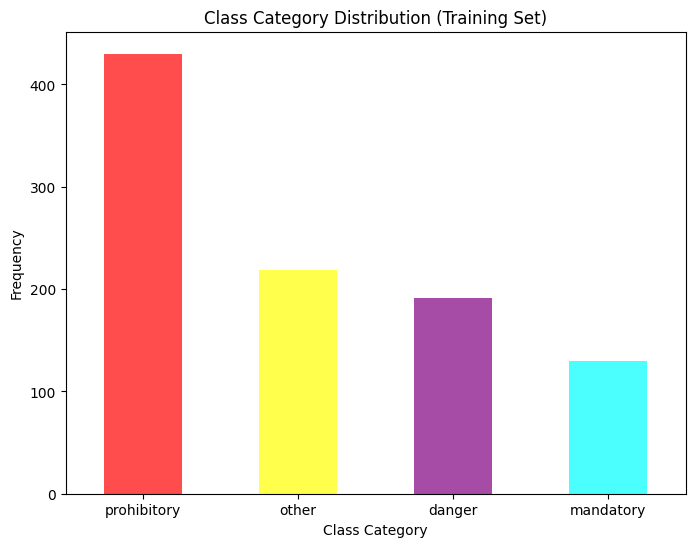

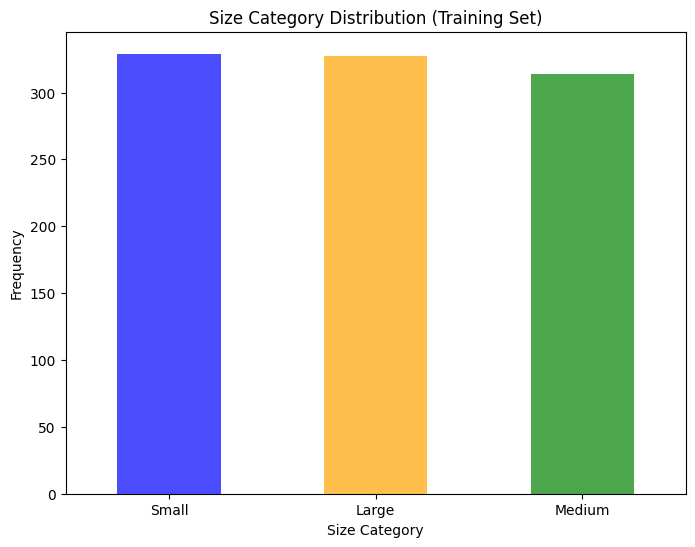

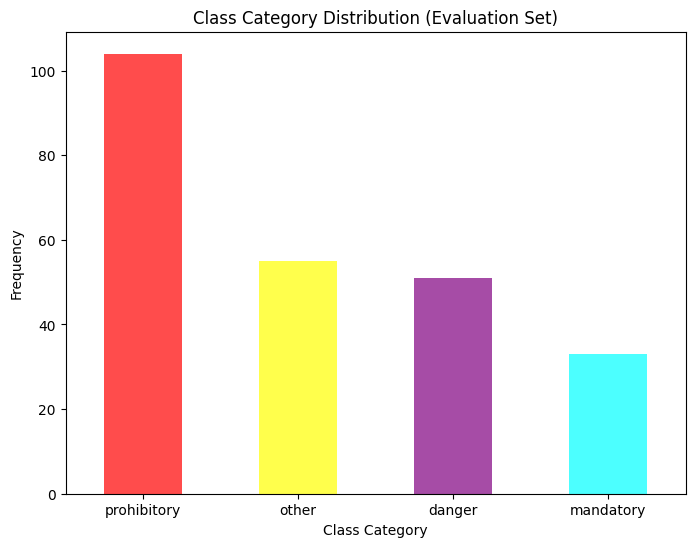

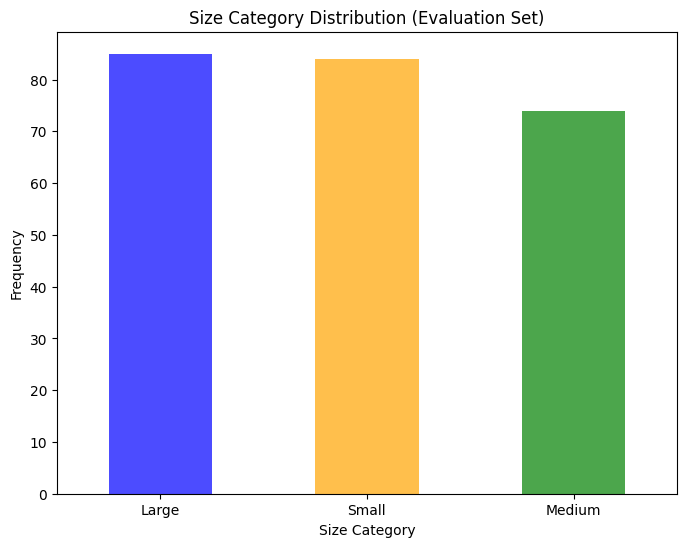

In [110]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and evaluation sets (80% train, 20% eval)
train_annotations, eval_annotations = train_test_split(
    annotations, test_size=0.2, random_state=42, stratify=annotations["TotalClassID"]
)

# Save the split information
train_annotations.to_csv("./data/train_annotations.csv", index=False)
eval_annotations.to_csv("./data/eval_annotations.csv", index=False)

# Function to plot histograms for class and size distributions
def plot_histograms(data, title_suffix):
    # Class category histogram
    class_counts = data["ClassCategory"].value_counts()
    plt.figure(figsize=(8, 6))
    class_counts.plot(kind="bar", color=["red", "yellow", "purple", "cyan"], alpha=0.7)
    plt.title(f"Class Category Distribution ({title_suffix})")
    plt.xlabel("Class Category")
    plt.ylabel("Frequency")
    plt.xticks(rotation=0)
    plt.show()

    # Size category histogram
    size_counts = data["SizeCategory"].value_counts()
    plt.figure(figsize=(8, 6))
    size_counts.plot(kind="bar", color=["blue", "orange", "green"], alpha=0.7)
    plt.title(f"Size Category Distribution ({title_suffix})")
    plt.xlabel("Size Category")
    plt.ylabel("Frequency")
    plt.xticks(rotation=0)
    plt.show()

# Plot histograms for training set
plot_histograms(train_annotations, "Training Set")

# Plot histograms for evaluation set
plot_histograms(eval_annotations, "Evaluation Set")


In [111]:
import torch
import torchvision
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.models.detection.ssd import SSD300_VGG16_Weights
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import xml.etree.ElementTree as ET
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F
from torchvision.transforms import Compose, Resize, ToTensor

# Custom Dataset class
class GTSDBDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, image_dir, transforms=None,model_input=True):
        self.annotations = annotations
        self.image_dir = image_dir
        self.transforms = transforms
        self.model_input = model_input
        self.grouped_annotations = self.annotations.groupby("Image")
        self.images_lists = list(self.grouped_annotations.groups.keys())

    def __len__(self):
        return len(self.images_lists)

    def __getitem__(self, idx):
        # Get the file name and image path
        filename = self.images_lists[idx]
        img_path = f"{self.image_dir}/{filename}"
        img = Image.open(img_path).convert("RGB")

        # Get all rows corresponding to this image
        image_annotations = self.grouped_annotations.get_group(filename)

        # Extract all bounding boxes and labels for this image
        boxes = image_annotations[["LeftCol", "TopRow", "RightCol", "BottomRow"]].values.astype(float)
        labels = image_annotations["TotalClassID"].values

        if self.model_input == True:
            # Original dimensions of the image
            orig_width, orig_height = img.size

            # Resize the image to 300x300
            img = img.resize((300, 300))
            scale_x = 300 / orig_width
            scale_y = 300 / orig_height

            # Scale bounding boxes
            boxes[:, [0, 2]] *= scale_x  # Scale x-coordinates (LeftCol, RightCol)
            boxes[:, [1, 3]] *= scale_y  # Scale y-coordinates (TopRow, BottomRow)

        # Convert to PyTorch tensors
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

def get_transform():
    transforms = []
    transforms.append(ToTensor())  # Convert image to tensor
    return Compose(transforms)


# Create DataLoaders
train_dataset = GTSDBDataset(train_annotations, "./data/FullIJCNN2013", get_transform())
eval_dataset = GTSDBDataset(eval_annotations, "./data/FullIJCNN2013", get_transform())

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
eval_loader = DataLoader(eval_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [ ]:
import torch
import torchvision
from torchvision.models.detection.ssd import SSD300_VGG16_Weights
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load Pretrained SSD300 Model
model = torchvision.models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)
num_classes = 5  # Background + 4 class for traffic signs
model.head.classification_head.num_classes = num_classes

model = model.to(device)

In [114]:
import torch.optim as optim
from tqdm import tqdm

# Optimizer and learning rate scheduler
optimizer = optim.SGD(model.parameters(), lr=0.0004, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in tqdm(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {losses.item()}")


100%|██████████| 162/162 [00:11<00:00, 13.71it/s]


Epoch 1, Loss: 4.36489200592041


100%|██████████| 162/162 [00:11<00:00, 13.91it/s]


Epoch 2, Loss: 4.613051414489746


100%|██████████| 162/162 [00:12<00:00, 13.35it/s]


Epoch 3, Loss: 1.7617918252944946


100%|██████████| 162/162 [00:12<00:00, 13.34it/s]


Epoch 4, Loss: 3.861029863357544


100%|██████████| 162/162 [00:11<00:00, 13.67it/s]


Epoch 5, Loss: 2.2795865535736084


100%|██████████| 162/162 [00:11<00:00, 13.90it/s]


Epoch 6, Loss: 1.9721527099609375


100%|██████████| 162/162 [00:11<00:00, 13.97it/s]


Epoch 7, Loss: 2.3649585247039795


100%|██████████| 162/162 [00:11<00:00, 13.96it/s]


Epoch 8, Loss: 2.9211173057556152


100%|██████████| 162/162 [00:11<00:00, 13.74it/s]


Epoch 9, Loss: 2.761744737625122


100%|██████████| 162/162 [00:11<00:00, 13.88it/s]

Epoch 10, Loss: 2.578577995300293


# Evaluate

In [115]:
def scale_bounding_boxes(bboxes, old_width, old_height, new_width, new_height):

    scale_x = new_width / old_width
    scale_y = new_height / old_height
    
    scaled_bboxes = []
    for bbox in bboxes:
        left = bbox[0] * scale_x
        top = bbox[1] * scale_y
        right = bbox[2] * scale_x
        bottom = bbox[3] * scale_y
        scaled_bboxes.append([left, top, right, bottom])
    
    return scaled_bboxes

def scale_bounding_boxes_pred(bbox, old_width, old_height, new_width, new_height):

    scale_x = new_width / old_width
    scale_y = new_height / old_height
    
    bbox = bbox[0]
    left = bbox[0] * scale_x
    top = bbox[1] * scale_y
    right = bbox[2] * scale_x
    bottom = bbox[3] * scale_y
    
    return [left, top, right, bottom]

In [116]:
predictions = []
ground_truths = []

eval_dataset = GTSDBDataset(eval_annotations, "./data/FullIJCNN2013", get_transform(train=False))

eval_loader = DataLoader(eval_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

model.eval()

with torch.no_grad():
    for images, targets in tqdm(eval_loader):
        
        images = [img.to(device) for img in images]

        # Generate predictions
        outputs = model(images)

        # Collect predictions
        for output in outputs:
            predictions_dict = {"boxes":[],"labels":[],"scores":[]}
            for i in range(len(output)):
                if output["scores"][i].cpu().numpy() > 0.1 :
                    predictions_dict["boxes"].append(scale_bounding_boxes_pred([output["boxes"][i].cpu().numpy()],300,300,1360,800))
                    predictions_dict["labels"].append(output["labels"][i].cpu().numpy())
                    predictions_dict["scores"].append(output["scores"][i].cpu().numpy())
            
            predictions.append(predictions_dict)

        # Collect ground truths
        for target in targets:
            ground_truths.append({
                "boxes": scale_bounding_boxes(target["boxes"].cpu().numpy(),300,300,1360,800),
                "labels": target["labels"].cpu().numpy()
            })

eval_dataset = GTSDBDataset(eval_annotations, "./data/FullIJCNN2013", get_transform(train=False),model_input=False)

eval_loader = DataLoader(eval_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

100%|██████████| 54/54 [00:06<00:00,  8.62it/s]


In [117]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import functional as F

## mAP and IoU Evaluation

In [118]:
def calculate_iou(box_a, box_b):
    x_min = max(box_a[0], box_b[0])
    y_min = max(box_a[1], box_b[1])
    x_max = min(box_a[2], box_b[2])
    y_max = min(box_a[3], box_b[3])

    intersection = max(0, x_max - x_min + 1) * max(0, y_max - y_min + 1)
    area_a = (box_a[2] - box_a[0] + 1) * (box_a[3] - box_a[1] + 1)
    area_b = (box_b[2] - box_b[0] + 1) * (box_b[3] - box_b[1] + 1)
    union = area_a + area_b - intersection

    if union == 0:
        return 0
    return intersection / union

def calculate_map(predictions, ground_truths, iou_threshold=0.5):
    average_precisions = []

    for class_id in range(1,5):  # ["prohibitory", "danger", "mandatory", "other"]
        class_predictions = []
        class_ground_truths = []

        for pred, gt in zip(predictions, ground_truths):
            # Filter predictions and ground truth for the current class
            class_predictions.extend(
                [(box, score) for box, score, label in zip(pred["boxes"], pred["scores"], pred["labels"]) if label == class_id]
            )
            class_ground_truths.extend([box for box, label in zip(gt["boxes"], gt["labels"]) if label == class_id])

        # Sort predictions by confidence score
        class_predictions = sorted(class_predictions, key=lambda x: x[1], reverse=True)

        true_positives = np.zeros(len(class_predictions))
        false_positives = np.zeros(len(class_predictions))
        matched = []

        for i, (pred_box, score) in enumerate(class_predictions):
            found_match = False
            for gt_box in class_ground_truths:
                if (
                    calculate_iou(pred_box, gt_box) > iou_threshold
                    and not any(np.array_equal(gt_box, m) for m in matched)
                ):
                    true_positives[i] = 1
                    matched.append(gt_box)
                    found_match = True
                    break
            if not found_match:
                false_positives[i] = 1

        # Calculate precision and recall
        tp_cumsum = np.cumsum(true_positives)
        fp_cumsum = np.cumsum(false_positives)
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
        recalls = tp_cumsum / len(class_ground_truths)

        # Interpolated average precision
        precisions = np.concatenate(([0], precisions, [0]))
        recalls = np.concatenate(([0], recalls, [1]))

        for j in range(len(precisions) - 1, 0, -1):
            precisions[j - 1] = max(precisions[j - 1], precisions[j])

        indices = np.where(recalls[1:] != recalls[:-1])[0]
        average_precisions.append(np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1]))

    return np.mean(average_precisions)


In [119]:
iou_threshold = 0.5
map_score = calculate_map(predictions, ground_truths, iou_threshold=iou_threshold)
print(f"Mean Average Precision (mAP) at IoU={iou_threshold}: {map_score:.4f}")

Mean Average Precision (mAP) at IoU=0.5: 0.4035


## AP Graph

In [120]:
def plot_ap_graph(predictions, ground_truths):
    import matplotlib.pyplot as plt

    iou_thresholds = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    ap_scores = {class_id: [] for class_id in range(1,5)}  # ["prohibitory", "danger", "mandatory", "other"]

    for iou in iou_thresholds:
        for class_id in range(1,5):
            class_predictions = []
            class_ground_truths = []

            for pred, gt in zip(predictions, ground_truths):
                # Filter predictions and ground truths for the current class
                class_predictions.extend(
                    [(box, score) for box, score, label in zip(pred["boxes"], pred["scores"], pred["labels"]) if label == class_id]
                )
                class_ground_truths.extend([box for box, label in zip(gt["boxes"], gt["labels"]) if label == class_id])

            # Sort predictions by confidence score
            class_predictions = sorted(class_predictions, key=lambda x: x[1], reverse=True)

            true_positives = np.zeros(len(class_predictions))
            false_positives = np.zeros(len(class_predictions))
            matched = []

            for i, (pred_box, score) in enumerate(class_predictions):
                found_match = False
                for gt_box in class_ground_truths:
                    if (
                        calculate_iou(pred_box, gt_box) > iou
                        and not any(np.array_equal(gt_box, m) for m in matched)
                    ):
                        true_positives[i] = 1
                        matched.append(gt_box)
                        found_match = True
                        break
                if not found_match:
                    false_positives[i] = 1

            # Calculate precision and recall
            tp_cumsum = np.cumsum(true_positives)
            fp_cumsum = np.cumsum(false_positives)
            precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)
            recalls = tp_cumsum / len(class_ground_truths)

            # Interpolated average precision
            precisions = np.concatenate(([0], precisions, [0]))
            recalls = np.concatenate(([0], recalls, [1]))

            for j in range(len(precisions) - 1, 0, -1):
                precisions[j - 1] = max(precisions[j - 1], precisions[j])

            indices = np.where(recalls[1:] != recalls[:-1])[0]
            ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])
            ap_scores[class_id].append(ap)

    # Plot the AP graph
    plt.figure(figsize=(10, 6))
    for class_id, scores in ap_scores.items():
        plt.plot(iou_thresholds, scores, label=f"Class {class_id} AP")

    plt.xlabel("IoU Threshold")
    plt.ylabel("Average Precision")
    plt.title("AP Graph for Different IoU Thresholds")
    plt.legend(["Prohibitory", "Danger", "Mandatory", "Other"])
    plt.grid()
    plt.show()


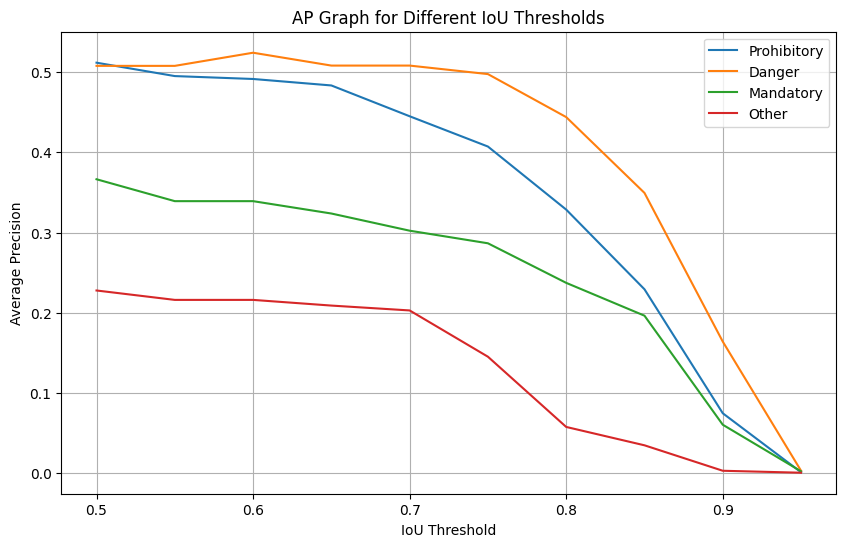

In [121]:
plot_ap_graph(predictions, ground_truths)

## Diverse mAP by Size

In [122]:
def create_size_mapping(annotations):
    size_mapping = {
        "small": [],
        "medium": [],
        "large": []
    }

    for anno in annotations:
        for box in anno["boxes"]:
            width = box[2] - box[0]  # RightCol - LeftCol
            if width < 32:
                size_mapping["small"].append(anno)
            elif 32 <= width <= 45:
                size_mapping["medium"].append(anno)
            else:
                size_mapping["large"].append(anno)

    return size_mapping

# Generate size mappings for predictions and ground truths
size_mapping_predictions = create_size_mapping(predictions)
size_mapping_ground_truths = create_size_mapping(ground_truths)


In [123]:
def calculate_map_by_size(pred_size_mapping,gt_size_mapping):
    iou_threshold = 0.5
    map_by_size = {}

    for size in pred_size_mapping.keys():

        # Compute mAP for the filtered data
        map_by_size[size] = calculate_map(pred_size_mapping[size], gt_size_mapping[size], iou_threshold)

    return map_by_size

# Calculate Diverse mAP
size_map = calculate_map_by_size(size_mapping_predictions,size_mapping_ground_truths)
print(f"Diverse mAP: {size_map}")


Diverse mAP: {'small': 0.007868501358329446, 'medium': 0.04859479793441707, 'large': 0.2637711170802693}


## Plot AP

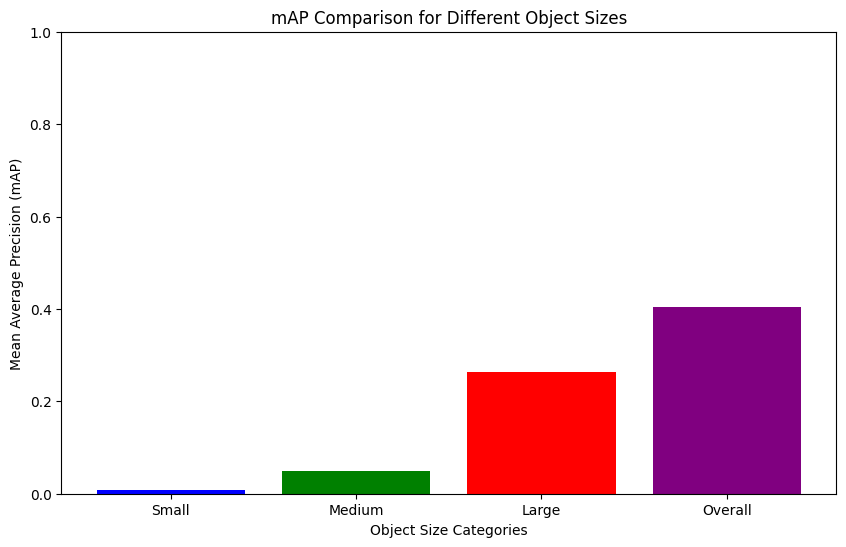

In [124]:
import matplotlib.pyplot as plt

# Calculate the overall mAP (across all sizes)
overall_map = calculate_map(predictions, ground_truths, iou_threshold=0.5)

# Prepare the data for the bar chart
labels = ["Small", "Medium", "Large", "Overall"]
map_values = [size_map.get("small", 0), size_map.get("medium", 0), size_map.get("large", 0), overall_map]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, map_values, color=["blue", "green", "red", "purple"])

plt.title("mAP Comparison for Different Object Sizes")
plt.xlabel("Object Size Categories")
plt.ylabel("Mean Average Precision (mAP)")
plt.ylim(0, 1)  # Set the y-axis range (0 to 1 for mAP values)
plt.show()


## Predict and Visualize

In [ ]:
!pip install adjustText

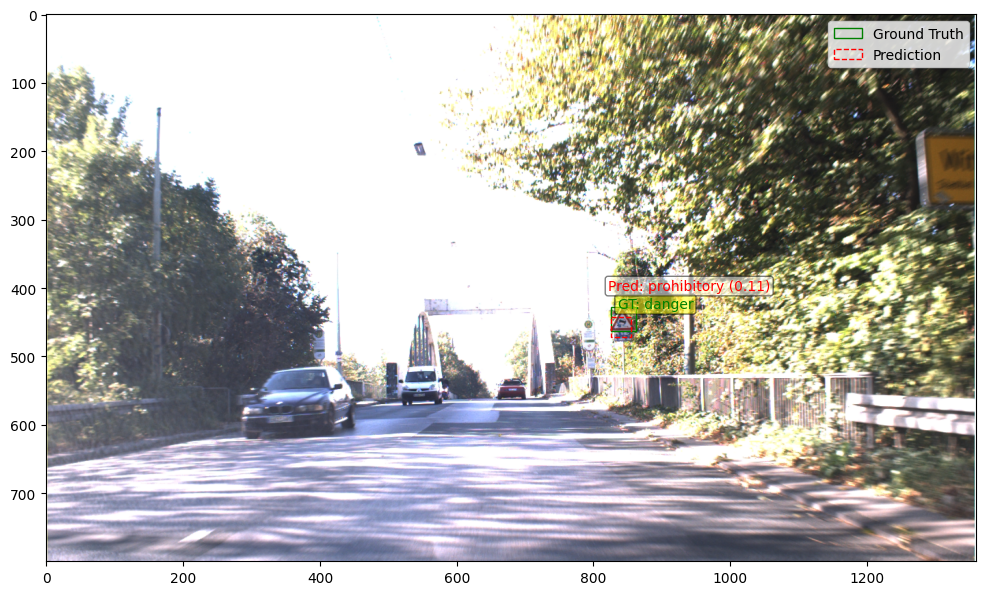

In [126]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from adjustText import adjust_text
from matplotlib.patches import Patch

# Mapping of class numbers to names
class_mapping = {
    1: "prohibitory",
    2: "danger",
    3: "mandatory",
    4: "other",
}

def visualize_predictions_with_adjust(image, ground_truth, prediction, threshold=0.5):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    texts = []  # Collect text objects to adjust

    # Draw ground truth boxes
    for box, label in zip(ground_truth["boxes"], ground_truth["labels"]):
        rect = Rectangle(
            (box[0], box[1]),  # x, y
            box[2] - box[0],  # width
            box[3] - box[1],  # height
            linewidth=1, edgecolor="green", facecolor="none"
        )
        ax.add_patch(rect)

        # Add text for ground truth with class name
        class_name = class_mapping.get(label.item(), "Unknown")
        text = ax.text(
            box[0], box[1] - 5,
            f"GT: {class_name}",
            color="green", fontsize=10,
            bbox=dict(facecolor="yellow", edgecolor="black", boxstyle="round,pad=0.2", alpha=0.5)
        )
        texts.append(text)

    # Draw predicted boxes, only if the score is greater than the threshold
    for box, label, score in zip(prediction["boxes"], prediction["labels"], prediction["scores"]):
        if score >= threshold:
            rect = Rectangle(
                (box[0], box[1]),  # x, y
                box[2] - box[0],  # width
                box[3] - box[1],  # height
                linewidth=1, edgecolor="red", linestyle="--", facecolor="none"
            )
            ax.add_patch(rect)

            # Add text for prediction with class name and score
            class_name = class_mapping.get(label.item(), "Unknown")
            text = ax.text(
                box[0], box[1] - 20,
                f"Pred: {class_name} ({score:.2f})",
                color="red", fontsize=10,
                bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2", alpha=0.5)
            )
            texts.append(text)

    # Adjust text positions to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle="->", color="gray"))

    # Create legend
    legend_elements = [
        Patch(edgecolor="green", facecolor="none", linewidth=1, label="Ground Truth"),
        Patch(edgecolor="red", facecolor="none", linestyle="--", linewidth=1, label="Prediction"),
    ]
    ax.legend(handles=legend_elements, loc="upper right")

    plt.show()

idx = 5  # Pick an image from eval_loader
image, target = eval_dataset[idx]
predicted = predictions[idx]

# Set a threshold for the predictions to display
threshold_value = 0.1
visualize_predictions_with_adjust(image.permute(1, 2, 0).numpy(), ground_truths[idx], predicted, threshold=threshold_value)


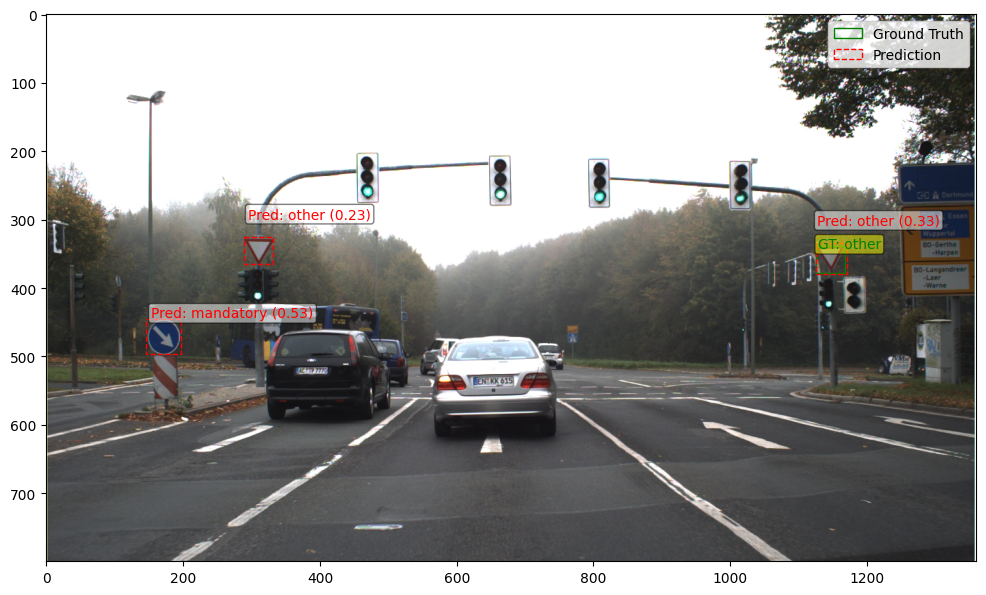

In [127]:
idx = 30  # Pick an image from eval_loader
image, target = eval_dataset[idx]
predicted = predictions[idx]

# Set a threshold for the predictions to display
threshold_value = 0.2  
visualize_predictions_with_adjust(image.permute(1, 2, 0).numpy(), ground_truths[idx], predicted, threshold=threshold_value)


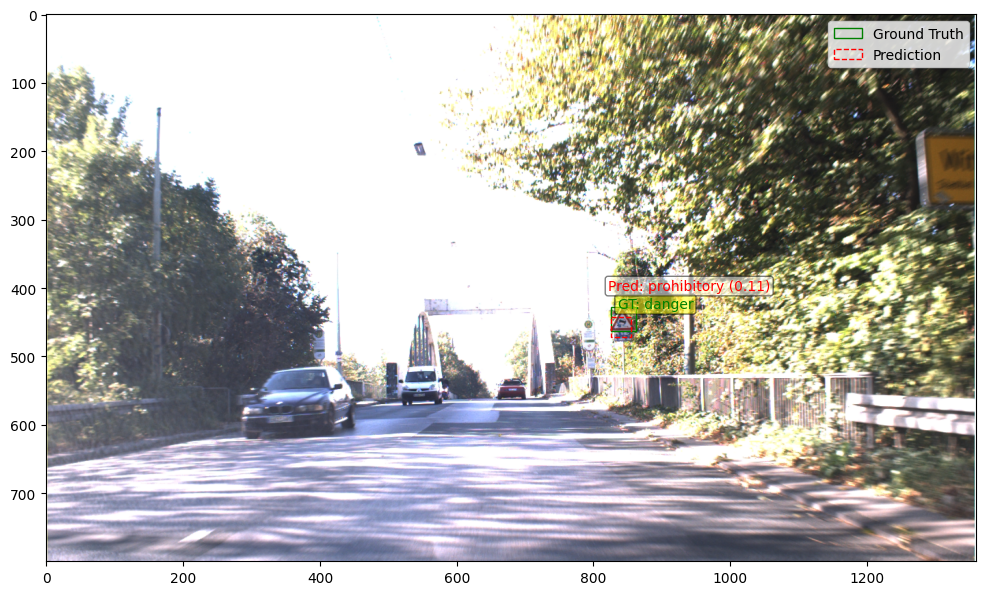

In [128]:
idx = 5  # Pick an image from eval_loader
image, target = eval_dataset[idx]
predicted = predictions[idx]

# Set a threshold for the predictions to display
threshold_value = 0.0
visualize_predictions_with_adjust(image.permute(1, 2, 0).numpy(), ground_truths[idx], predicted, threshold=threshold_value)
